# Switching energy surfaces

## Define the common parameters, set up the energy surfaces, and define a streamlined set of functions for efficient looping.

Load in a ton of stuff here. This could be optimized, but it's easy to keep appending when running interactively.

In [47]:
from __future__ import division, print_function
import numpy as np
import scipy as sc
from scipy import signal
import math as math
from math import pi
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.ticker import FormatStrFormatter
import decimal
import sys
from numpy import genfromtxt
import glob
import datetime
import inspect

In [48]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


A couple of functions to fuss with the aesthetics are defined here to save some time later.

In [49]:
def adjust_spines(ax, spines, plot_margin = 0 ):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])
        
    x0, x1, y0, y1 = ax.axis()
    ax.axis((x0 - plot_margin,
          x1 + plot_margin,
          y0 - plot_margin,
          y1 + plot_margin))

        
def white_out(fig, facecolor = 'white'):
    # See http://stackoverflow.com/questions/24542610/matplotlib-figure-facecolor-alpha-while-saving-background-color-transparency
    if facecolor is False:
        # Not all graphs get color-coding
        facecolor = fig.get_facecolor()
        alpha = 1
    else:
        alpha = 0.5
    color_with_alpha = colorConverter.to_rgba(facecolor, alpha)
    fig.patch.set_facecolor(color_with_alpha)    

## How sensitive is flux and power to the intra-surface and inter-surface rate prefactors?

The forward and reverse rates are effectively given by an equation of the form:
$$
k = C \exp \left( \frac{-\Delta E_{ij}}{\mathrm{k}T} \right)
$$
where $\Delta E_{ij}$ are adjacent bins on a single landscape for the intra-surface rate equation and $\Delta E_{ij}$ is the same bin on the two energy surfaces for the inter-surface rate equation. To be extra explict, we have:
$$
\begin{aligned}
k_\text{intra-surface} &= C_\text{intra-surface} = \left( \frac{-\Delta E_{ij}}{\mathrm{k}T} \right) \quad \mbox{for $i, j$ as adjacent bins along on each surface, and} \\
k_\text{inter-surface} &= C_\text{inter-surface} = \left( \frac{-\Delta E_{i}}{\mathrm{k}T} \right) \quad \mbox{for $i$ between surfaces}.
\end{aligned}
$$
First, we have to redefine the functions that generate the rate matrix (this is called once per energy surface) and transition matrix to take in parameters `prefactor_intra` and `prefactor_inter`.

In [50]:
def setup_rate_matrix(energy_surface, kT, prefactor_intra=1):
    """
    Returns a rate matrix based on an energy surface that has the forward
    and backward rate constants. These rate matrices are not normalized 
    (so entries) may be greater than 1 and the rows do /not/ sum to 1.
    """
    C = prefactor_intra
    bins = len(energy_surface)
    forward_rates = C * np.exp(-1 * np.diff(energy_surface) / 
                               float(2 * kT))
    backward_rates = C * np.exp(+1 * np.diff(energy_surface) / 
                                float(2 * kT))
    rate_matrix = np.zeros((bins, bins))
    for i in range(bins - 1):
        rate_matrix[i][i + 1] = forward_rates[i]
        rate_matrix[i + 1][i] = backward_rates[i]
    rate_matrix[0][bins - 1] = C * np.exp(-(energy_surface[bins - 1] - 
                                            energy_surface[0]) / float(2 * kT))
    rate_matrix[bins - 1][0] = C * np.exp(+(energy_surface[bins - 1] - 
                                            energy_surface[0]) / float(2 * kT))

    return rate_matrix

In [51]:
def setup_transition_matrix(unbound, bound, energy_cat, k_cat_bin, kT,
                            dt=None, inter=1.0, intra=1.0, text=None, 
                            name=None):
    """
    Returns a normalized transition matrix that is composed of two rate matrices. 
    The transition matrix is mostly empty (zero). It has elements on the diagonal, 
    upper diagonal, lower diagonal, and off-diagonal elements in the first and last 
    row of each rate matrix to account for boundary conditions.
    """
    C = inter
    assert len(unbound) == len(bound)
    bins = len(unbound)
    energy_delta = bound - unbound
    transition_matrix = np.zeros((2 * bins, 2 * bins))

    transition_matrix[0:bins, 0:bins] = setup_rate_matrix(unbound, kT, prefactor_intra=intra)
    transition_matrix[bins:2 * bins, bins:2 * bins] = setup_rate_matrix(bound, kT, prefactor_intra=intra)

    transition_rates_unbound_to_bound = C * np.exp(-1 * (bound - unbound) / float(2 * kT))
    transition_rates_bound_to_unbound = C * np.exp(+1 * (bound - unbound) / float(2 * kT))

    transition_rates_bound_to_unbound[k_cat_bin] = C * \
                                                   np.exp(+1 * (energy_delta[k_cat_bin] + energy_cat) / float(2 * kT))

    for i in range(bins):
        transition_matrix[i, i + bins] = transition_rates_unbound_to_bound[i]
        transition_matrix[i + bins, i] = transition_rates_bound_to_unbound[i]
    maximum_rate_constant_order = int(math.log10(transition_matrix.max()))

    if not dt:
        # Changed from +1 to +2 during power scan to eliminate errors.
        dt = 10 ** -(maximum_rate_constant_order + 2)
    transition_matrix *= dt

    if np.any(transition_matrix > 1):
        print('Transition matrix elements greater than 1.')
        print('Multiplying transition matrix by 0.1. Inspect manually.')
        print(transition_matrix.max())
        transition_matrix *= 0.1
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    if np.any(row_sums > 1):
        print('Row sums unexpectedly greater than 1.')
        print('Will likely have a negative element in the transition matrix.')
        print('unbound    = {}'.format(unbound))
        print('bound      = {}'.format(bound))
        print('energy_cat = {}'.format(energy_cat))
        print('k_cat_bin  = {}'.format(k_cat_bin))
        print('kT         = {}'.format(kT))
        print('dt         = {}'.format(dt))
        print('inter      = {}'.format(inter))
        print('intra      = {}'.format(intra))
        print(row_sums)
    for i in range(2 * bins):
        transition_matrix[i][i] = 1.0 - row_sums[i]
    # Use 6 decimal places to check, because there are small variances around 9th decimal.
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    if not np.all(np.round(row_sums, 6) == 1):
        print('Row sums unexpectedly not equal to 1.')
        print(row_sums)
    nonzero_entries = 0
    for row in transition_matrix:
        nonzero_entries += np.count_nonzero(row)
    nonzero_entries /= len(transition_matrix)
    if nonzero_entries != 4:
        print('Unexpected number of nonzero entries in the transition matrix.')
        print(transition_matrix[0])

    return transition_matrix, dt

In [52]:
def calculate_flux(ss, transition_matrix, norm):
    """
    This function returns the flux BETWEEN two bins. Taking the steady state
    population in one bin and multiplying it by the probability of moving to the
    next bin and taking the steady state population in the next bin and
    multiplying it by the probability of going to the previous bin. This returns
    a 2D array with (position, flux value).
    """

    bins = int(len(ss) / 2)
    if norm == 'single':
        ss[0:bins] /= np.sum(ss[0:bins])
        ss[bins:2 * bins] /= np.sum(ss[bins:2 * bins])
    if norm == 'global':
        ss /= np.sum(ss)

    # Flux ALONG
    flux_unbound = np.zeros((bins, 2))
    flux_bound = np.zeros((bins, 2))
    flux_between = np.zeros((bins, 2))
    for i in range(0, bins - 1):
        this_bin = i
        next_bin = i + 1
        f = ss[this_bin] * transition_matrix[this_bin][next_bin] - ss[next_bin] * transition_matrix[next_bin][this_bin]
        flux_unbound[i] = [i + 0.5, f]
    this_bin = bins - 1
    next_bin = 0
    f = ss[this_bin] * transition_matrix[this_bin][next_bin] - ss[next_bin] * transition_matrix[next_bin][this_bin]
    flux_unbound[bins - 1] = [bins - 1 + 0.5, f]

    for i in range(bins, 2 * bins - 1):
        this_bin = i
        next_bin = i + 1
        f = ss[this_bin] * transition_matrix[this_bin][next_bin] - ss[next_bin] * transition_matrix[next_bin][this_bin]
        flux_bound[i - bins] = [i + 0.5 - bins, f]
    this_bin = 2 * bins - 1
    next_bin = bins
    f = ss[this_bin] * transition_matrix[this_bin][next_bin] - ss[next_bin] * transition_matrix[next_bin][this_bin]
    flux_bound[bins - 1] = [bins - 1 + 0.5, f]

    # Flux BETWEEN
    for i in range(0, bins):
        this_bin = i
        next_bin = i + bins
        f = ss[this_bin] * transition_matrix[this_bin][next_bin] - ss[next_bin] * transition_matrix[next_bin][this_bin]

        flux_between[i] = [i, f]

    return (flux_unbound, flux_bound, flux_between)

## Determine the effect of the intra-surface transition rates, the inter-surface transition rates, and the catalytic energy on the net flux along the two surfaces

This function is named `zulu` because it calculates the $z$ axis values given a set of $(x,y)$ coordinates. In this case, $(x,y)$ are either the intra-surface rates, the inter-surface rates, or the catalytic energy. In other words, this function allows us to ask: given two variables spanning two ranges, what is the net flux on the unbound and bound energy surfaces?

In [53]:
def zulu(intra_factor, inter_factor, catalytic_energy, k_cat_bin):
    """

    :rtype : float
    """
    transition_matrix, dt = setup_transition_matrix(
                            unbound_energies, bound_energies,
                            catalytic_energy, k_cat_bin, kT,
                            inter=inter_factor,
                            intra=intra_factor)
    eigenvalues, eigenvectors = np.linalg.eig(transition_matrix.T)
    ss = eigenvectors[:, eigenvalues.argmax()].astype(float)
    ss /= np.sum(ss)
    flux_unbound, flux_bound, flux_between = \
    calculate_flux(ss, transition_matrix, norm='global')
    flux_unbound[:, 1] /= dt
    flux_bound[:, 1] /= dt
    flux_between[:, 1] /= dt

    return flux_unbound[0, 1] + flux_bound[0, 1]

In [54]:
def plot_scan(xx, yy, zz, xlabel, ylabel, title, xlog=True, ylog=True):
    fig, ax = plt.subplots()
    if ylog == True:
        ax.set_yscale('log')
    if xlog == True:
        ax.set_xscale('log')
    ax.margins(x = 0, y = 0)
    cmap = mpl.cm.jet
    zz = np.array(zz)
    if ylog == True:
        im = ax.pcolor(xx, yy, zz, 
            norm=LogNorm(vmin=zz.min(), vmax=zz.max()), 
            cmap=cmap)
    else:
        im = ax.pcolor(xx, yy, zz, 
            cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size = "10%", pad = 0.05)
    cbar = plt.colorbar(im, cax = cax)
    ax.set_title(title, y=1.05)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
/home/dslochower/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


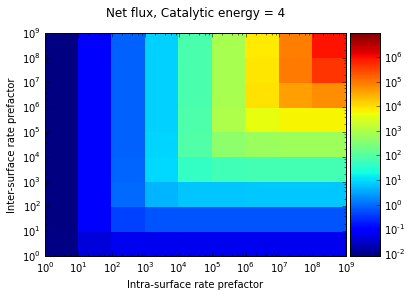

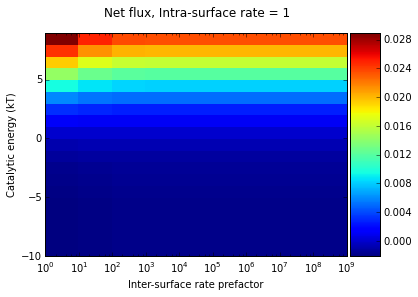

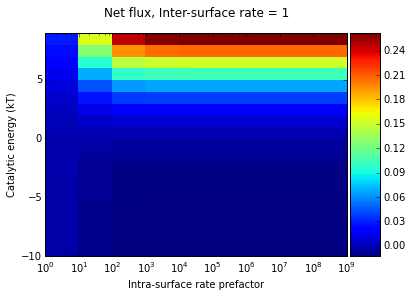

In [55]:
dx = 1
kT = 1
norms = ['single', 'global']
norm = norms[1]
unbound_energies = np.array([0.4, 0, 2, 1.6, 1.2, 0.8])
bound_energies = np.array([-0.4, -0.8, -1.2, -1.6, -2.0, 0])

x = 10.0 ** np.arange(-0.0, 10.0)
y = 10.0 ** np.arange(-0.0, 10.0)
catalytic_energy = 4
k_cat_bin = 4
z = [[zulu(spaghetti_western, shock_and_awe, catalytic_energy, k_cat_bin) 
    for spaghetti_western in x] 
    for shock_and_awe in y] 

plot_scan(x, y, z, 
         xlabel='Intra-surface rate prefactor',
         ylabel='Inter-surface rate prefactor',
         title='Net flux, Catalytic energy = {}'.format(catalytic_energy),
         xlog=True,
         ylog=True)

e = np.arange(-10, 10)
intra_surface = 10 ** 0
z = [[zulu(intra_surface, shock_and_awe, romcom, k_cat_bin) 
    for shock_and_awe in y] 
    for romcom in e]

plot_scan(x, e, z, 
         xlabel='Inter-surface rate prefactor',
         ylabel='Catalytic energy (kT)',
         title='Net flux, Intra-surface rate = {}'.format(intra_surface),
         xlog=True,
         ylog=False)


inter_surface = 10 ** 0
z = [[zulu(spaghetti_western, inter_surface, romcom, k_cat_bin) 
    for spaghetti_western in x] 
    for romcom in e]

plot_scan(y, e, z, 
     xlabel='Intra-surface rate prefactor',
     ylabel='Catalytic energy (kT)',
     title='Net flux, Inter-surface rate = {}'.format(inter_surface),
     xlog=True,
     ylog=False)

Now, let's calculate the excess enery in the system due to catalysis. This is going to be $(P_i E_i)$ calculated using the nonequilibrium steady state eigenvector minus $(P_i E_i)$ calculated using the PDF, based purely on the energy surfaces without any catalysis.

In [56]:
def excesss_energy(intra_factor, inter_factor, catalytic_energy, k_cat_bin):
    
    transition_matrix, dt = setup_transition_matrix(
                            unbound_energies, bound_energies,
                            catalytic_energy, k_cat_bin, kT,
                            inter=inter_factor,
                            intra=intra_factor)
    eigenvalues, eigenvectors = np.linalg.eig(transition_matrix.T)
    ss = eigenvectors[:, eigenvalues.argmax()].astype(float)
    ss /= np.sum(ss)
    boltzmann_unbound = np.exp(-unbound_energies/kT)
    boltzmann_bound   = np.exp(-bound_energies/kT)
    pdf_unbound       = boltzmann_unbound / \
                        np.sum((boltzmann_unbound+boltzmann_bound)*dx)
    pdf_bound         = boltzmann_bound / \
                        np.sum((boltzmann_unbound+boltzmann_bound)*dx)
    eq_unbound = pdf_unbound * unbound_energies
    eq_bound   = pdf_bound * bound_energies
    bins = len(unbound_energies)
    noneq_unbound = ss[0:bins] * unbound_energies
    noneq_bound   = ss[bins:2*bins] * bound_energies
    unbound_diff = np.sum(noneq_unbound - eq_unbound)
    bound_diff   = np.sum(noneq_bound - eq_bound)
    
    return unbound_diff, bound_diff

In [57]:
dx = 1
kT = 1
norms = ['single', 'global']
norm = norms[1]
unbound_energies = np.array([0.4, 0, 2, 1.6, 1.2, 0.8])
bound_energies = np.array([-0.4, -0.8, -1.2, -1.6, -2.0, 0])

k_cat_bin = 4

e = np.arange(-10, 10)
excess = [excesss_energy(intra_factor = 1.0, 
               inter_factor = 1.0, 
               catalytic_energy = asdf,
               k_cat_bin = k_cat_bin) for asdf in e]

/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: ComplexWarning: Casting complex values to real discards the imaginary part


/home/dslochower/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


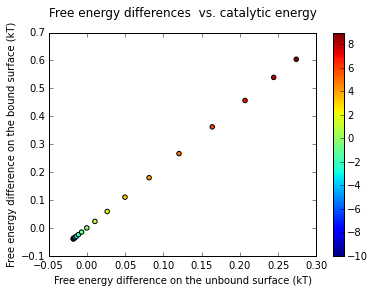

In [58]:
plt.figure()
plt.scatter(np.array(excess)[:,0], np.array(excess)[:,1], c=e)
plt.xlabel('Free energy difference on the unbound surface (kT)')
plt.ylabel('Free energy difference on the bound surface (kT)')
plt.title('Free energy differences  vs. catalytic energy', y=1.05)
plt.colorbar()


In [59]:
def entropy_maybe(intra_factor, inter_factor, catalytic_energy, k_cat_bin):
    
    transition_matrix, dt = setup_transition_matrix(
                            unbound_energies, bound_energies,
                            catalytic_energy, k_cat_bin, kT,
                            inter=inter_factor,
                            intra=intra_factor)
    eigenvalues, eigenvectors = np.linalg.eig(transition_matrix.T)
    ss = eigenvectors[:, eigenvalues.argmax()].astype(float)
    ss /= np.sum(ss)
    boltzmann_unbound = np.exp(-unbound_energies/kT)
    boltzmann_bound   = np.exp(-bound_energies/kT)
    pdf_unbound       = boltzmann_unbound / \
                        np.sum((boltzmann_unbound+boltzmann_bound)*dx)
    pdf_bound         = boltzmann_bound / \
                        np.sum((boltzmann_unbound+boltzmann_bound)*dx)
    eq_unbound = -pdf_unbound * np.log(pdf_unbound)
    eq_bound   = -pdf_bound * np.log(pdf_bound)
    bins = len(unbound_energies)
    noneq_unbound = -ss[0:bins] * np.log(ss[0:bins])
    noneq_bound   = -ss[bins:2*bins] * np.log(ss[bins:2*bins])
    unbound_diff = np.sum(noneq_unbound - eq_unbound)
    bound_diff   = np.sum(noneq_bound - eq_bound)
    
    return unbound_diff, bound_diff

In [60]:
dx = 1
kT = 1
norms = ['single', 'global']
norm = norms[1]
unbound_energies = np.array([0.4, 0, 2, 1.6, 1.2, 0.8])
bound_energies = np.array([-0.4, -0.8, -1.2, -1.6, -2.0, 0])

k_cat_bin = 4

e = np.arange(-10, 10)
entropy = [entropy_maybe(intra_factor = 1.0, 
               inter_factor = 1.0, 
               catalytic_energy = asdf,
               k_cat_bin = k_cat_bin) for asdf in e]

/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: ComplexWarning: Casting complex values to real discards the imaginary part


/home/dslochower/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


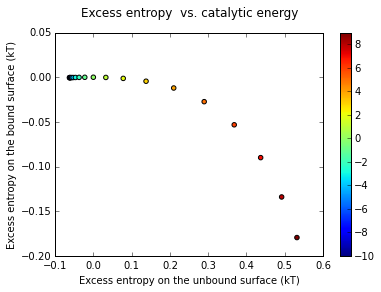

In [61]:
plt.figure()
plt.scatter(np.array(entropy)[:,0], np.array(entropy)[:,1], c=e)
plt.xlabel('Excess entropy on the unbound surface (kT)')
plt.ylabel('Excess entropy on the bound surface (kT)')
plt.title('Excess entropy  vs. catalytic energy', y=1.05)
plt.colorbar()


## Now, let's define a load for the motor to work against

In [62]:
bins = len(unbound_energies)
E_load = np.linspace(0, 1, bins)

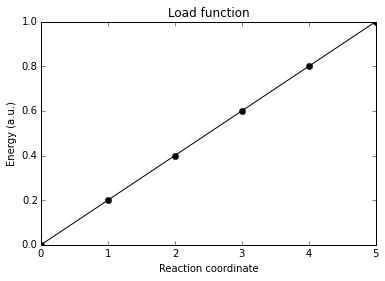

In [63]:
plt.figure()
plt.plot(range(len(E_load)), E_load, 'ko-')
plt.title('Load function')
plt.xlabel('Reaction coordinate')
plt.ylabel('Energy (a.u.)')
plt.show()

Let's define some candidate functions, then measure the net flux as a function of these candidate functions.

In [64]:
def generate_candidates(low, high):
    "Generate some candidate load functions within some parameter space."
    bins = len(unbound_energies)
    load = np.linspace(low, high, bins)
    return load

In [65]:
def flux_load(candidate):
    "Return the net flux on energy landscapes modified by a candidate function."
    dx               = 1
    kT               = 1
    k_cat_bin        = 4
    catalytic_energy = 4
    
    unbound_energies = np.array([0.4, 0, 2, 1.6, 1.2, 0.8])
    bound_energies   = np.array([-0.4, -0.8, -1.2, -1.6, -2.0, 0])
    unbound_energies += candidate
    bound_energies   += candidate
    
    transition_matrix, dt = setup_transition_matrix(
                            unbound_energies, bound_energies,
                            catalytic_energy, k_cat_bin, kT,
                            inter=1.0,
                            intra=1.0)
    eigenvalues, eigenvectors = np.linalg.eig(transition_matrix.T)
    ss = eigenvectors[:, eigenvalues.argmax()].astype(float)
    ss /= np.sum(ss)
    flux_unbound, flux_bound, flux_between = \
    calculate_flux(ss, transition_matrix, norm='global')
    flux_unbound[:, 1] /= dt
    flux_bound[:, 1] /= dt
    flux_between[:, 1] /= dt
    assert [flux_unbound[i, 1] + flux_bound[i, 1] == 
            flux_unbound[i+1,1] + flux_bound[i+1,1] for i in range(len(flux_bound)-1)]
    return flux_unbound[0, 1] + flux_bound[0, 1]


/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/home/dslochower/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


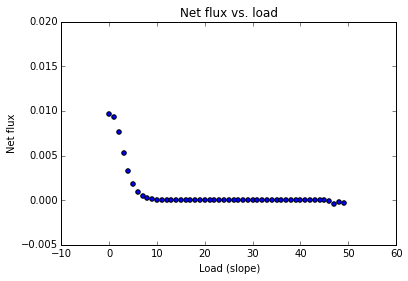

In [66]:
plt.figure()
plt.title('Net flux vs. load')
plt.xlabel('Load (slope)')
plt.ylabel('Net flux')
i = 0
for j in np.arange(0, 50):
    E_load = generate_candidates(i, j)
    flux   = flux_load(E_load)
    plt.scatter(j, flux)
plt.show()    

In [67]:
def compute_power(candidate):
    "Return the net flux on energy landscapes modified by a candidate function."
    dx               = 1
    kT               = 1
    k_cat_bin        = 4
    catalytic_energy = 4
    
    unbound_energies = np.array([0.4, 0, 2, 1.6, 1.2, 0.8])
    bound_energies   = np.array([-0.4, -0.8, -1.2, -1.6, -2.0, 0])
    unbound_energies += candidate
    bound_energies   += candidate
    
    transition_matrix, dt = setup_transition_matrix(
                            unbound_energies, bound_energies,
                            catalytic_energy, k_cat_bin, kT,
                            inter=1.0,
                            intra=1.0)
    eigenvalues, eigenvectors = np.linalg.eig(transition_matrix.T)
    ss = eigenvectors[:, eigenvalues.argmax()].astype(float)
    ss /= np.sum(ss)
    flux_unbound, flux_bound, flux_between = \
    calculate_flux(ss, transition_matrix, norm='global')
    flux_unbound[:, 1] /= dt
    flux_bound[:, 1] /= dt
    flux_between[:, 1] /= dt
    assert [flux_unbound[i, 1] + flux_bound[i, 1] == 
            flux_unbound[i+1,1] + flux_bound[i+1,1] for i in range(len(flux_bound)-1)]
    
    bins = len(flux_unbound[:, 1])
    unbound_difference              = np.zeros((bins))
    unbound_difference[0:bins - 1]  = np.diff(unbound_energies)
    unbound_difference[-1]          =  unbound_energies[-1] - unbound_energies[0]
    bound_difference                = np.zeros((len(flux_bound[:, 1])))
    bound_difference[0:bins -1]     = np.diff(bound_energies)
    bound_difference[-1]            = bound_energies[-1] - bound_energies[0]

    # P = np.sum(flux_unbound[:, 1] * unbound_difference + flux_bound[:, 1] * bound_difference)
    load_slope = float(candidate[-1] - candidate[0]) / len(candidate)
    P = np.sum(flux_unbound[:, 1] + flux_bound[:, 1]) * load_slope
    return P 


/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/home/dslochower/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


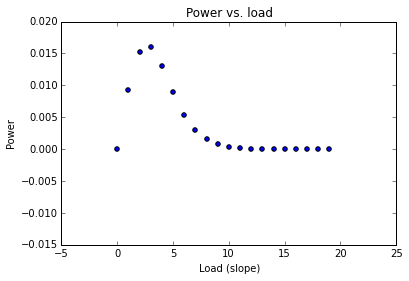

In [68]:
plt.figure()
plt.title('Power vs. load')
plt.xlabel('Load (slope)')
plt.ylabel('Power')
i = 0
for j in np.arange(0, 20):
    E_load = generate_candidates(i, j)
    power  = compute_power(E_load)
    plt.scatter(j, power)
plt.show()    

Now we need to redefine the `rate_matrix` and `transition_matrix` functions to specially handle the load energies across the PBC. This means that we can't simply use an *effective* energy that is the sum of the underlying energy forces and the load energy. These functions now need to be aware of the difference between the underlying energy landscapes and the load energy.

In [69]:
np.hstack((unbound_energies, unbound_energies))

array([ 0.4,  0. ,  2. ,  1.6,  1.2,  0.8,  0.4,  0. ,  2. ,  1.6,  1.2,
        0.8])

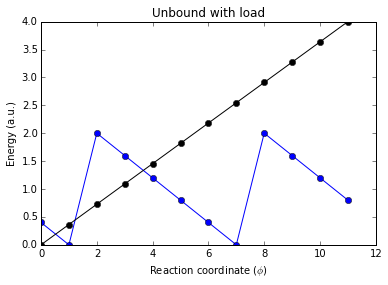

In [70]:
plt.figure()
plt.title('Unbound with load')
plt.xlabel('Reaction coordinate ($\phi$)')
plt.ylabel('Energy (a.u.)')
load = np.linspace(0, 4, len(unbound_energies) * 2)
plt.plot(range(len(unbound_energies)*2), np.hstack((unbound_energies, unbound_energies)), 'bo-')
plt.plot(range(len(load)), load, 'ko-')
plt.show()    

In [71]:
def transition_matrix_with_load(unbound, bound, energy_cat, k_cat_bin, load, 
                            kT, dt=None, inter=1.0, intra=1.0, text=None, 
                            name=None):
    """
    Returns a normalized transition matrix that is composed of two rate matrices. 
    The transition matrix is mostly empty (zero). It has elements on the diagonal, 
    upper diagonal, lower diagonal, and off-diagonal elements in the first and last 
    row of each rate matrix to account for boundary conditions.
    
    This function is now aware of the difference between the underlying energy surfaces
    and the load energy that the motor is working against.
    """
    C = inter
    assert len(unbound) == len(bound)
    bins = len(unbound)
    energy_delta = (bound + load) - (unbound + load)
    transition_matrix = np.zeros((2 * bins, 2 * bins))

    C              = intra
    energy_surface = (unbound + load)
    bins           = len(energy_surface)
    forward_rates  = C * np.exp(-1 * np.diff(energy_surface) / float(2 * kT))
    backward_rates = C * np.exp(+1 * np.diff(energy_surface) / float(2 * kT))
    rate_matrix    = np.zeros((bins, bins))
    for i in range(bins - 1):
        rate_matrix[i][i + 1] = forward_rates[i]
        rate_matrix[i + 1][i] = backward_rates[i]
    # Now, reset the energy surface back to the "bare" underlying values.
    load_increment = float(load[-1] - load[0]) / len(load)
    # if not load_increment >= 0:
    #     raise IOError('load_increment = {}'.format(load_increment))
    # For the PBC, make sure load[0] > load[-1], so the load force is always increasing.
    rate_matrix[0][bins - 1] = C * np.exp(-((unbound[bins - 1] - 
                                            unbound[0]) + load_increment) / float(2 * kT))
    rate_matrix[bins - 1][0] = C * np.exp(+((unbound[bins - 1] - 
                                            unbound[0]) + load_increment) / float(2 * kT))
    transition_matrix[0:bins, 0:bins] = rate_matrix

    C              = intra
    energy_surface = (bound + load)
    bins           = len(energy_surface)
    forward_rates  = C * np.exp(-1 * np.diff(energy_surface) / float(2 * kT))
    backward_rates = C * np.exp(+1 * np.diff(energy_surface) / float(2 * kT))
    rate_matrix    = np.zeros((bins, bins))
    for i in range(bins - 1):
        rate_matrix[i][i + 1] = forward_rates[i]
        rate_matrix[i + 1][i] = backward_rates[i]
    # Now, reset the energy surface back to the "bare" underlying values.
    load_increment = float(load[-1] - load[0]) / len(load)
    # if not load_increment >= 0:
    #     raise IOError('load_increment = {}'.format(load_increment))
    # For the PBC, make sure load[0] > load[-1], so the load force is always increasing.
    rate_matrix[0][bins - 1] = C * np.exp(-((bound[bins - 1] - 
                                            bound[0]) + load_increment) / float(2 * kT))
    rate_matrix[bins - 1][0] = C * np.exp(+((bound[bins - 1] - 
                                            bound[0]) + load_increment) / float(2 * kT))
    
    transition_matrix[bins:2 * bins, bins:2 * bins] = rate_matrix
    
    C = inter
    transition_rates_unbound_to_bound = C * np.exp(-1 * (bound - unbound) / float(2 * kT))
    transition_rates_bound_to_unbound = C * np.exp(+1 * (bound - unbound) / float(2 * kT))

    transition_rates_bound_to_unbound[k_cat_bin] = C * \
                                                   np.exp(+1 * (energy_delta[k_cat_bin] + energy_cat) / float(2 * kT))

    for i in range(bins):
        transition_matrix[i, i + bins] = transition_rates_unbound_to_bound[i]
        transition_matrix[i + bins, i] = transition_rates_bound_to_unbound[i]
    maximum_rate_constant_order = int(math.log10(transition_matrix.max()))

    if not dt:
        # Changed from +1 to +2 during power scan to eliminate errors.
        dt = 10 ** -(maximum_rate_constant_order + 2)
    transition_matrix *= dt

    if np.any(transition_matrix > 1):
        print('Transition matrix elements greater than 1.')
        print('Multiplying transition matrix by 0.1. Inspect manually.')
        print(transition_matrix.max())
        transition_matrix *= 0.1
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    if np.any(row_sums > 1):
        print('Row sums unexpectedly greater than 1.')
        print('Will likely have a negative element in the transition matrix.')
        print('unbound    = {}'.format(unbound))
        print('bound      = {}'.format(bound))
        print('energy_cat = {}'.format(energy_cat))
        print('k_cat_bin  = {}'.format(k_cat_bin))
        print('kT         = {}'.format(kT))
        print('dt         = {}'.format(dt))
        print('inter      = {}'.format(inter))
        print('intra      = {}'.format(intra))
        print(row_sums)
    for i in range(2 * bins):
        transition_matrix[i][i] = 1.0 - row_sums[i]
    # Use 6 decimal places to check, because there are small variances around 9th decimal.
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    if not np.all(np.round(row_sums, 6) == 1):
        print('Row sums unexpectedly not equal to 1.')
        print(row_sums)
    nonzero_entries = 0
    for row in transition_matrix:
        nonzero_entries += np.count_nonzero(row)
    nonzero_entries /= len(transition_matrix)
    if nonzero_entries != 4:
        print('Unexpected number of nonzero entries in the transition matrix.')
        print(transition_matrix[0])

    return transition_matrix, dt

In [72]:
def compute_power(candidate, multiplier=1.0):
    "Return the net flux on energy landscapes modified by a candidate function."
    dx               = 1
    kT               = 1
    k_cat_bin        = 4
    catalytic_energy = 4
    # print('N.B. catalysis is now zero.')
    
    # unbound_energies = multiplier * np.array([0.4, 0, 2, 1.6, 1.2, 0.8])
    # bound_energies   = multiplier * np.array([-0.4, -0.8, -1.2, -1.6, -2.0, 0])
    unbound_energies = np.array([ 0.4,  0.0,  2.0 * multiplier, 1.6, 1.2, 0.8])
    bound_energies   = np.array([-0.4, -0.8, -1.2, -1.6, -2.0, 0.0])
    # Do not simply lump the energies together.
    # Pass along the candidate to the transition_matrix function for proper
    # PBC handling.
    # unbound_energies += candidate
    # bound_energies   += candidate
    
    transition_matrix, dt = transition_matrix_with_load(
                            unbound_energies, bound_energies,
                            catalytic_energy, k_cat_bin, candidate, kT,
                            inter=1.0,
                            intra=1.0)
    eigenvalues, eigenvectors = np.linalg.eig(transition_matrix.T)
    ss = eigenvectors[:, eigenvalues.argmax()].astype(float)
    ss /= np.sum(ss)
    flux_unbound, flux_bound, flux_between = \
    calculate_flux(ss, transition_matrix, norm='global')
    flux_unbound[:, 1] /= dt
    flux_bound[:, 1] /= dt
    flux_between[:, 1] /= dt
        
    assert [flux_unbound[i, 1] + flux_bound[i, 1] == 
            flux_unbound[i+1,1] + flux_bound[i+1,1] for i in range(len(flux_bound)-1)]
    
    unbound_energies += candidate
    bound_energies   += candidate
    
    bins = len(flux_unbound[:, 1])
    # unbound_difference              = np.zeros((bins))
    # unbound_difference[0:bins - 1]  = np.diff(unbound_energies)
    # unbound_difference[-1]          =  unbound_energies[-1] - unbound_energies[0]
    # bound_difference                = np.zeros((len(flux_bound[:, 1])))
    # bound_difference[0:bins -1]     = np.diff(bound_energies)
    # bound_difference[-1]            = bound_energies[-1] - bound_energies[0]

    # P = np.sum(flux_unbound[:, 1] * unbound_difference + flux_bound[:, 1] * bound_difference)
    load_slope = float(candidate[-1] - candidate[0]) / len(candidate)
    P = np.sum(flux_unbound[:, 1] + flux_bound[:, 1]) * load_slope
    F = flux_unbound[0, 1] + flux_bound[0, 1]
    return P, F, ss


Load		Power		Net flux
-10.000000	-1.395507	0.139551
-9.000000	-1.195089	0.132788
-8.000000	-0.995712	0.124464
-7.000000	-0.802668	0.114667
-6.000000	-0.620957	0.103493
-5.000000	-0.455127	0.091025
-4.000000	-0.309250	0.077313
-3.000000	-0.187054	0.062351
-2.000000	-0.092188	0.046094
-1.000000	-0.028502	0.028502
0.000000	0.000000	0.009658
1.000000	-0.010106	-0.010106
2.000000	-0.060305	-0.030153
3.000000	-0.148913	-0.049638
4.000000	-0.270912	-0.067728
5.000000	-0.418923	-0.083785
6.000000	-0.584564	-0.097427
7.000000	-0.759526	-0.108504
8.000000	-0.936177	-0.117022
9.000000	-1.107859	-0.123095

/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
/home/dslochower/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


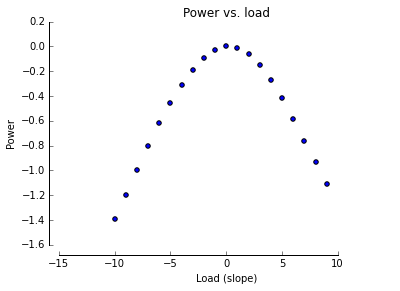

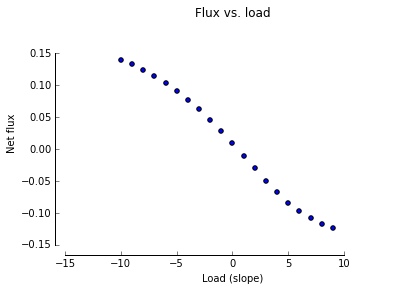

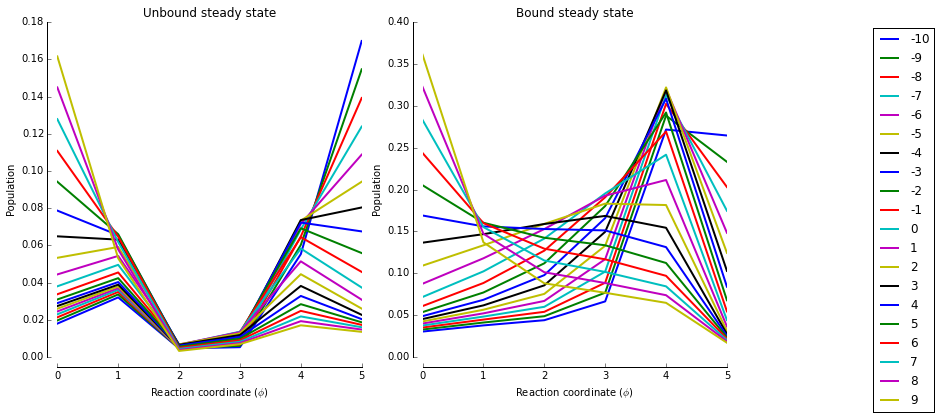

In [73]:
fig1, (ax1) = plt.subplots(nrows=1, ncols=1)
fig2, (ax2) = plt.subplots(nrows=1, ncols=1)
fig3, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

ax1.set_title('Power vs. load')
ax1.set_xlabel('Load (slope)')
ax1.set_ylabel('Power')
ax2.set_title('Flux vs. load')
ax2.set_xlabel('Load (slope)')
ax2.set_ylabel('Net flux')
ax3.set_title('Unbound steady state')
ax3.set_xlabel('Reaction coordinate ($\phi$)')
ax3.set_ylabel('Population')
ax4.set_title('Bound steady state')
ax4.set_xlabel('Reaction coordinate ($\phi$)')
ax4.set_ylabel('Population')

print('Load\t\tPower\t\tNet flux')
low  = -10
high = 10
n    = (high - low) + 1
color=mpl.cm.rainbow(np.linspace(0, 1, n))
i = 0
for j, clr in zip(np.arange(low, high), color):
    E_load = generate_candidates(i, j)
    power, flux, ss = compute_power(E_load)
    ax1.scatter(j, power)
    ax2.scatter(j, flux)
    bins = int(len(ss)/2)
    ax3.plot(range(bins), ss[0:bins], c=clr, label=j, lw=2)
    ax4.plot(range(bins), ss[bins:2*bins], c=clr, label=j, lw=2)    
    print('{:2f}\t{:2f}\t{:2f}'.format(j, power, flux))
ax4.legend(bbox_to_anchor=(1.7, 1.0))
adjust_spines(ax1, ['left', 'bottom'])
adjust_spines(ax2, ['left', 'bottom'])
adjust_spines(ax3, ['left', 'bottom'])
adjust_spines(ax4, ['left', 'bottom'])


plt.show()    

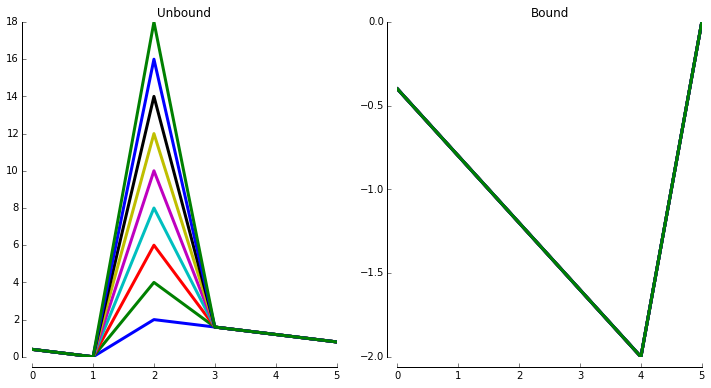

In [74]:
multiplier_low  = 1
multiplier_high = 10
multiplier_dx   = 1
rng = np.arange(multiplier_low, multiplier_high, multiplier_dx)
i = 0
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6), facecolor='white')
color = mpl.cm.rainbow(np.linspace(0, 1, len(rng)))

for value, c in zip(rng, color):
    unbound_energies = np.array([ 0.4,  0.0,  2.0 * value, 1.6, 1.2, 0.8])
    bound_energies   = np.array([-0.4, -0.8, -1.2, -1.6, -2.0, 0.0])
    bins = len(unbound_energies)
    ax1.plot(range(bins), unbound_energies, c=c, lw=3)
    ax2.plot(range(bins), bound_energies, c=c, lw=3)
    ax1.set_title('Unbound')
    ax2.set_title('Bound')
# plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0, 9)])
adjust_spines(ax1, ['left', 'bottom'])
adjust_spines(ax2, ['left', 'bottom'])
plt.show()
    

/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
/home/dslochower/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


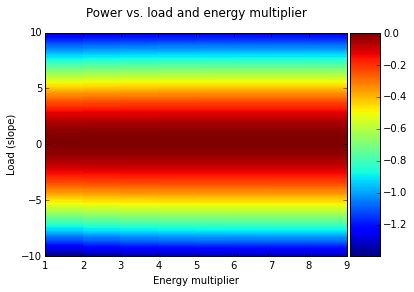

[-1.3312871522285612, -1.3122357099347668, -1.2931527164714114, -1.2740431184027008, -1.2549118726209214, -1.2357639546079477, -1.2166043467365539, -1.1974380416373971, -1.1782700376399249, -1.1591053333114707, -1.1399489294328611, -1.1208058233043421, -1.1016810071022849, -1.0825794675290441, -1.0635061779911104, -1.0444661033393439, -1.0254641902077279, -1.0065053694715287, -0.98759455471507573, -0.96873663514092567, -0.94993647791413061, -0.93119892286966188, -0.91252878484307887, -0.89393084465669803, -0.87540985568171181, -0.85697053662622669, -0.83861756881421057, -0.82035560101943061, -0.80218923994358327, -0.784123054494682, -0.76616157323671141, -0.74830928111124717, -0.7305706207732986, -0.7129499901345614, -0.69545174205030191, -0.67808018396398551, -0.66083957649244518, -0.64373413384941491, -0.62676802172842661, -0.60994536027103663, -0.59327022008413022, -0.57674662578588864, -0.56037855431970451, -0.54416993608052433, -0.52812465488062821, -0.51224654930503666, -0.496539

In [75]:
slope_low  = -10
slope_high = 10
slope_dx   = 0.1
multiplier_low  = 1
multiplier_high = 10
multiplier_dx   = 1
i = 0
fig, (ax) = plt.subplots(nrows=1, ncols=1)
powers = []

def zebra(load_slope, energy_multiplier):
        E_load = generate_candidates(0.0, load_slope)
        power, flux, ss = compute_power(E_load, energy_multiplier)
        return power

powers = [[zebra(i, j) for i in np.arange(slope_low, slope_high, slope_dx)] 
         for j in np.arange(multiplier_low, multiplier_high, multiplier_dx)]

xx = np.arange(multiplier_low, multiplier_high, multiplier_dx)
yy = np.arange(slope_low, slope_high, slope_dx)
z = np.array(powers)
#print(np.shape(z))
#zz = z.reshape(z, (len(xx), len(yy)))
cmap = mpl.cm.jet
im = ax.pcolor(xx, yy, z.T, cmap=cmap)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size = "10%", pad = 0.05)
cbar = plt.colorbar(im, cax = cax)
ax.set_title('Power vs. load and energy multiplier', y=1.05)
ax.set_xlabel('Energy multiplier')
ax.set_ylabel('Load (slope)')

plt.show()
print(max(powers))

Make the multipliers just raise the peak, and not the entire landscape, so the E_catalytic still has an effect.

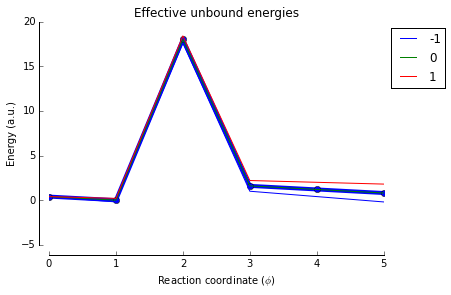

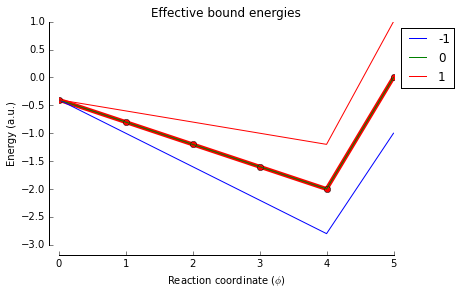

In [76]:
fig3, (ax3) = plt.subplots(nrows=1, ncols=1)
ax3.set_title('Effective unbound energies')
ax3.set_xlabel('Reaction coordinate ($\phi$)')
ax3.set_ylabel('Energy (a.u.)')
fig4, (ax4) = plt.subplots(nrows=1, ncols=1)
ax4.set_title('Effective bound energies')
ax4.set_xlabel('Reaction coordinate ($\phi$)')
ax4.set_ylabel('Energy (a.u.)')

ax3.plot(range(len(unbound_energies)), unbound_energies,'bo-', lw=4)
ax4.plot(range(len(bound_energies)), bound_energies,'ro-', lw=4)

i = 0
color=mpl.cm.rainbow(np.linspace(0, 1, 3))
for j, c in zip(np.arange(-1, 2), color):
    E_load = generate_candidates(i, j)
    ax3.plot(range(len(E_load)), E_load + unbound_energies, c=c, label=j)
    ax4.plot(range(len(E_load)), E_load + bound_energies, c=c, label=j)

ax3.legend()
ax3.legend(bbox_to_anchor=(1.2, 1.0))
ax4.legend()
ax4.legend(bbox_to_anchor=(1.2, 1.0))

adjust_spines(ax3, ['left', 'bottom'])
adjust_spines(ax4, ['left', 'bottom'])


plt.show()    


# What is the torsional diffusion time in our toy model?

Let's begin, as we've done before, setting the usual parameters $\mathrm{d}x$ and $\mathrm{k}T$. I'll begin by using the energy functions you suggested. 

In [77]:
dx               = 1
kT               = 1

unbound_energies = np.array([ 0.4,  0.0,  2.0,  1.6,  1.2, 0.8])
bound_energies   = np.array([-0.4, -0.8, -1.2, -1.6, -2.0, 0.0])
bins = len(unbound_energies)

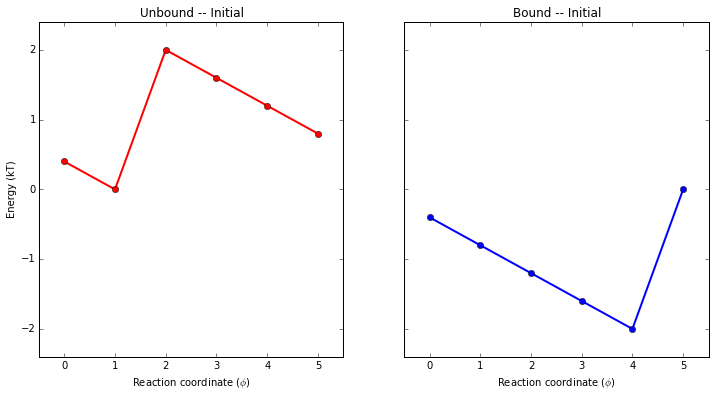

In [78]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize=(12,6))
ax1.plot(range(bins), unbound_energies, 'ro-', lw = 2)
ax2.plot(range(bins), bound_energies, 'bo-', lw = 2)
ax1.margins(x = 0.1, y = 0.1)
ax2.margins(x = 0.1, y = 0.1)

ax1.set_title('Unbound -- Initial')
ax1.set_xlabel('Reaction coordinate ($\phi$)')
ax1.set_ylabel('Energy (kT)')
ax2.set_title('Bound -- Initial')
ax2.set_xlabel('Reaction coordinate ($\phi$)')
plt.show()

I believe it will make things easy for us if we make these energy surfaces each have 12 bins, instead of just six. This is easy because our energy landscape is made up of line segments, so the interpolate should be pretty exact. If we *really* wanted to be exact, we would just use the equations for each line segement in the energy landscapes to make new points. But this is quicker.

In [79]:
from scipy.interpolate import interp1d
x = np.linspace(0, 5, num=6, endpoint=True)
f_u = interp1d(x, unbound_energies)
f_b = interp1d(x, bound_energies)

In [80]:
x_desired = np.linspace(0, 5, num=12, endpoint=True)
unbound_extrapolate = f_u(x_desired)
bound_extrapolate = f_b(x_desired)
bins = len(x_desired)

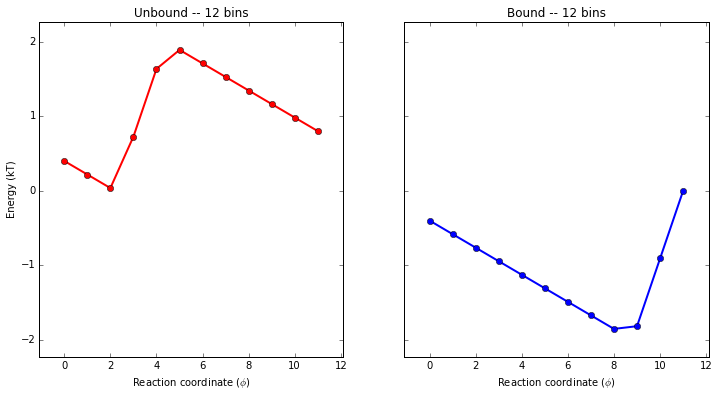

In [81]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize=(12,6))
ax1.plot(range(bins), unbound_extrapolate, 'ro-', lw = 2)
ax2.plot(range(bins), bound_extrapolate, 'bo-', lw = 2)
ax1.margins(x = 0.1, y = 0.1)
ax2.margins(x = 0.1, y = 0.1)

ax1.set_title('Unbound -- 12 bins')
ax1.set_xlabel('Reaction coordinate ($\phi$)')
ax1.set_ylabel('Energy (kT)')
ax2.set_title('Bound -- 12 bins')
ax2.set_xlabel('Reaction coordinate ($\phi$)')
plt.show()

Now that we've stretched the reaction coordinate, we also want to match the range of energies on the surfaces using Chris' MD simulations. Eyeballing this, I estimate the range to be about 15 kT. 

In [82]:
desired_range = 15
scale         = desired_range / max(unbound_extrapolate) # We know the min will be zero.
unbound_scale = scale * unbound_extrapolate
scale         = desired_range / max(abs(bound_extrapolate))
bound_scale   = scale * bound_extrapolate

We also want to match the energy offset between the surfaces. I'm going to specify the distance between the minimum of the unbound surface and the bound surface to be 14 kT. This is considering an ATP concentration of 1 M, an ADP concentration of 1 M, and an inorganic phosphate concentration of 1 M. It turns out these are reasonable estimates! (Kind of spooky). Here's a reference to the Bionumbers database description: http://book.bionumbers.org/how-much-energy-is-released-in-atp-hydrolysis/.

In [83]:
desired_offset = 14
min_unbound = min(unbound_scale)
min_bound   = min(bound_scale) # Here we do care about the sign.
rng         = min_unbound - min_bound
scale       = desired_offset / rng
bound_scale -= scale

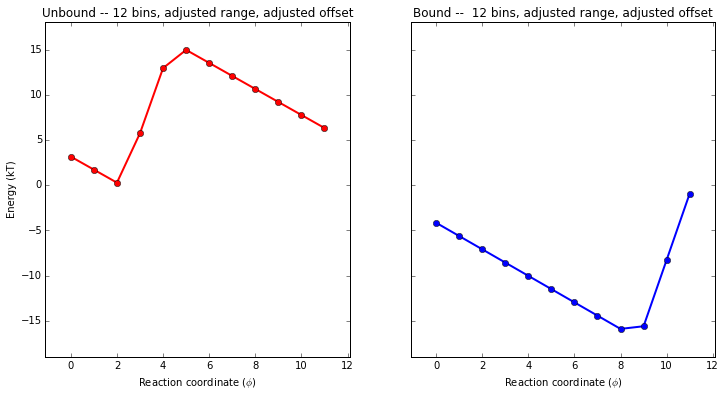

In [84]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize=(12,6))
ax1.plot(range(bins), unbound_scale, 'ro-', lw = 2)
ax2.plot(range(bins), bound_scale, 'bo-', lw = 2)
ax1.margins(x = 0.1, y = 0.1)
ax2.margins(x = 0.1, y = 0.1)

ax1.set_title('Unbound -- 12 bins, adjusted range, adjusted offset')
ax1.set_xlabel('Reaction coordinate ($\phi$)')
ax1.set_ylabel('Energy (kT)')
ax2.set_title('Bound --  12 bins, adjusted range, adjusted offset')
ax2.set_xlabel('Reaction coordinate ($\phi$)')
plt.show()

Great! Now there are 12 bins for the reaction coordinate, the range of energies on a single landscape is 15 kT, and the offset between the two energy landscapes is 14 kT between their minima.

Now, we calculate the transition matrix. I'm going to set the catalytic energy to be exactly equal to the offset between the surfaces, 14 kT. I'm also going to set the catalytic energy to act at the minimum of the bound surface. So this will make the energies equal at the the catalytic bin.

In [85]:
energy_cat = 14
k_cat_bin  = np.where(bound_extrapolate == min(bound_extrapolate))[0][0]
print('The catalytic energy is {} kT acting at bin {}.'.format(energy_cat, k_cat_bin))

The catalytic energy is 14 kT acting at bin 8.


Now, here we set $C$ for moving along a surface to be the value we've obtained from MD simulations. This is 0.00285 fs$^{-1}$.

In [86]:
C_intra = 0.00285
print('The rate prefactor for moving along a surface is {}'.format(C_intra))
# I believe this depends on matching the number of bins between analysis and model.

The rate prefactor for moving along a surface is 0.00285


We also have to set the rate prefactor for moving between surfaces. We're operating under the assumption that there is enough time to equilibrate on each surface between transitions between surfaecs. So, let's set this value to be one hundreth the value of of the intrasurface prefactor.

In [87]:
C_inter = 0.0000285
print('The rate prefactor for moving between surfaces is {}'.format(C_inter))

The rate prefactor for moving between surfaces is 2.85e-05


In [88]:
def setup_transition_matrix(unbound, bound, energy_cat, k_cat_bin, kT,
                            dt=None, inter=1.0, intra=1.0, text=None, 
                            name=None):
    """
    Returns a normalized transition matrix that is composed of two rate matrices. 
    The transition matrix is mostly empty (zero). It has elements on the diagonal, 
    upper diagonal, lower diagonal, and off-diagonal elements in the first and last 
    row of each rate matrix to account for boundary conditions.
    """
    C = inter
    assert len(unbound) == len(bound)
    bins = len(unbound)
    energy_delta = bound - unbound
    transition_matrix = np.zeros((2 * bins, 2 * bins))

    transition_matrix[0:bins, 0:bins] = setup_rate_matrix(unbound, kT, prefactor_intra=intra)
    transition_matrix[bins:2 * bins, bins:2 * bins] = setup_rate_matrix(bound, kT, prefactor_intra=intra)

    transition_rates_unbound_to_bound = C * np.exp(-1 * (bound - unbound) / float(2 * kT))
    transition_rates_bound_to_unbound = C * np.exp(+1 * (bound - unbound) / float(2 * kT))

    transition_rates_bound_to_unbound[k_cat_bin] = C * \
                                                   np.exp(+1 * (energy_delta[k_cat_bin] + energy_cat) / float(2 * kT))

    for i in range(bins):
        transition_matrix[i, i + bins] = transition_rates_unbound_to_bound[i]
        transition_matrix[i + bins, i] = transition_rates_bound_to_unbound[i]
    maximum_rate_constant_order = int(math.log10(transition_matrix.max()))

    if not dt:
        dt = 10 ** -(maximum_rate_constant_order + 1)
    transition_matrix *= dt

    if np.any(transition_matrix > 1):
        print('Transition matrix elements greater than 1.')
        print('Multiplying transition matrix by 0.1. Inspect manually.')
        print(transition_matrix.max())
        transition_matrix *= 0.1
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    if np.any(row_sums > 1):
        print('Row sums unexpectedly greater than 1.')
        print('Will likely have a negative element in the transition matrix.')
        print('unbound    = {}'.format(unbound))
        print('bound      = {}'.format(bound))
        print('energy_cat = {}'.format(energy_cat))
        print('k_cat_bin  = {}'.format(k_cat_bin))
        print('kT         = {}'.format(kT))
        print('dt         = {}'.format(dt))
        print('inter      = {}'.format(inter))
        print('intra      = {}'.format(intra))
        print(row_sums)
    for i in range(2 * bins):
        transition_matrix[i][i] = 1.0 - row_sums[i]
    # Use 6 decimal places to check, because there are small variances around 9th decimal.
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    if not np.all(np.round(row_sums, 6) == 1):
        print('Row sums unexpectedly not equal to 1.')
        print(row_sums)
    nonzero_entries = 0
    for row in transition_matrix:
        nonzero_entries += np.count_nonzero(row)
    nonzero_entries /= len(transition_matrix)
    if nonzero_entries != 4:
        print('Unexpected number of nonzero entries in the transition matrix.')
        print(transition_matrix[0])

    return transition_matrix, dt

In [89]:
def setup_rate_matrix(energy_surface, kT, prefactor_intra=1):
    """
    Returns a rate matrix based on an energy surface that has the forward
    and backward rate constants. These rate matrices are not normalized 
    (so entries) may be greater than 1 and the rows do /not/ sum to 1.
    """
    C = prefactor_intra
    bins = len(energy_surface)
    forward_rates = C * np.exp(-1 * np.diff(energy_surface) / 
                               float(2 * kT))
    backward_rates = C * np.exp(+1 * np.diff(energy_surface) / 
                                float(2 * kT))
    rate_matrix = np.zeros((bins, bins))
    for i in range(bins - 1):
        rate_matrix[i][i + 1] = forward_rates[i]
        rate_matrix[i + 1][i] = backward_rates[i]
    rate_matrix[0][bins - 1] = C * np.exp(-(energy_surface[bins - 1] - 
                                            energy_surface[0]) / float(2 * kT))
    rate_matrix[bins - 1][0] = C * np.exp(+(energy_surface[bins - 1] - 
                                            energy_surface[0]) / float(2 * kT))

    return rate_matrix

In [90]:
transition_matrix, dt = setup_transition_matrix(unbound_extrapolate, bound_extrapolate, energy_cat, k_cat_bin, kT, dt = 1, inter = C_inter, intra = C_intra)

In [91]:
eigenvalues, eigenvectors = np.linalg.eig(transition_matrix.T)
ss = eigenvectors[:, eigenvalues.argmax()].astype(float)
ss /= np.sum(ss)
boltzmann_unbound = np.exp(-unbound_scale/kT)
boltzmann_bound   = np.exp(-bound_scale/kT)
pdf_unbound       = boltzmann_unbound / \
                    np.sum((boltzmann_unbound+boltzmann_bound)*dx)
pdf_bound         = boltzmann_bound / \
                    np.sum((boltzmann_unbound+boltzmann_bound)*dx)

/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


/home/dslochower/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


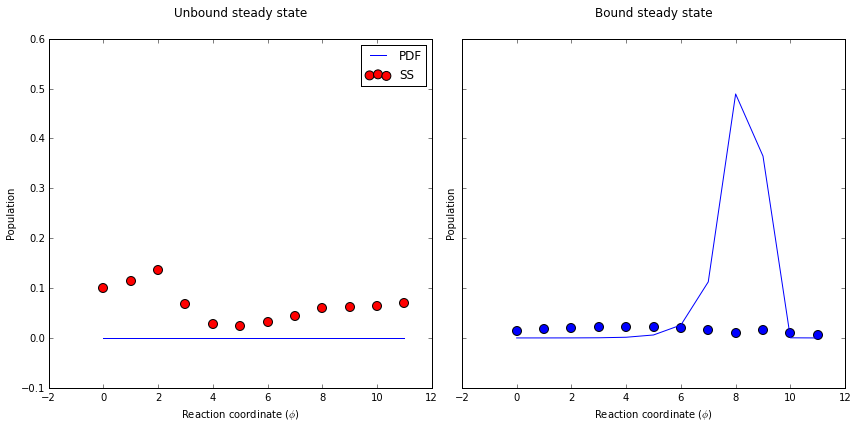

In [93]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize=(12,6))
ax1.scatter(range(bins), ss[0:bins], s=80, c='r', label='SS')
ax1.plot(range(bins), pdf_unbound, c='k', label='PDF')
ax1.legend()
ax1.set_title('Unbound steady state', y=1.05)
ax1.set_xlabel('Reaction coordinate ($\phi$)')
ax1.set_ylabel('Population')

ax2.scatter(range(bins), ss[bins:2*bins], s=80, c='b')
ax2.plot(range(bins), pdf_bound, c='k', label='PDF')
ax2.set_title('Bound steady state', y=1.05)
ax2.set_xlabel('Reaction coordinate ($\phi$)')
ax2.set_ylabel('Population')

fig.tight_layout()
plt.show()

Cool! Population is moving from the bound surface to the unbound surface and it's landing in bin 2 on the unbound surface -- the minimum. And the probability on the bound surface is pretty much evened out once the population moves out of bin 8.

In [94]:
-

In [95]:
flux_unbound, flux_bound, flux_between = calculate_flux(ss, transition_matrix, 'global')

In [96]:
flux_unbound[:, 1] /= dt
flux_bound[:, 1] /= dt
flux_between[:, 1] /= dt

In [97]:
assert [flux_unbound[i, 1] + flux_bound[i, 1] == 
        flux_unbound[i+1,1] + flux_bound[i+1,1] for i in range(len(flux_bound)-1)]
print('Flux along surfaces = {}'.format(flux_unbound[0, 1] + flux_bound[0, 1]))


Flux along surfaces = 6.801867061592241e-06


So this is the amount of population moving between bins, to the right, in time $\mathrm{d}t$ which is 1.0. We input $C$ in femtoseconds, so I think this makes $\mathrm{d}t = 1.0$ fs.

In [98]:
t = 1.0 / flux_unbound[0, 1] + flux_bound[0, 1]
print('In {:.3f} fs ({:.3f} ns), all population will move from bin $i$ to bin $i+1$.'.format(t, t/1e6))

In 93160.058 fs (0.093 ns), all population will move from bin $i$ to bin $i+1$.
